
Running hyperfine (very noisy) example...
Skipping tau=1.00e-06s (shorter than pi/2 pulse 1.55e-06s)


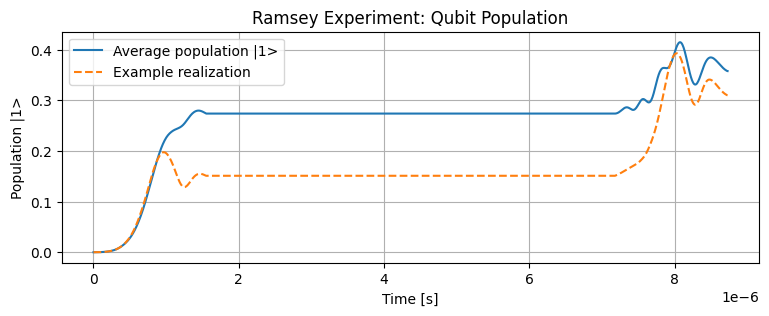

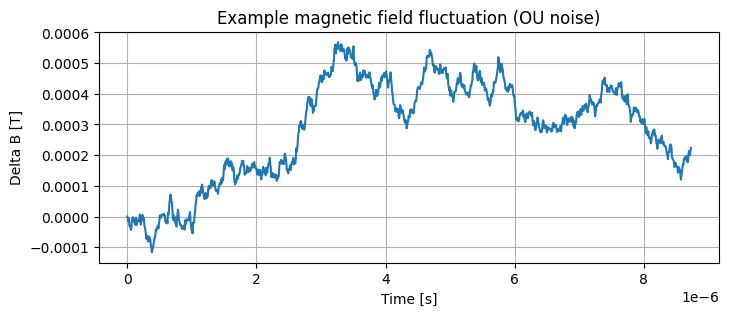

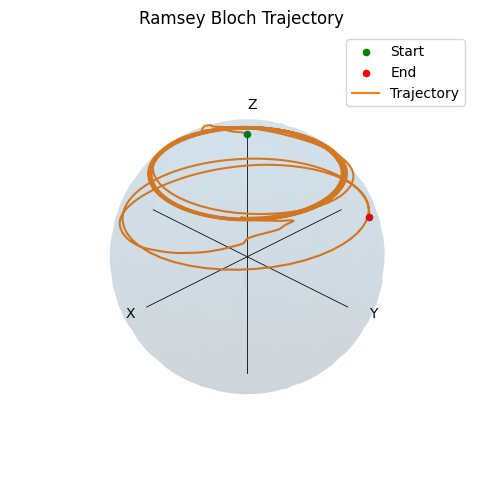

[hyperfine-verynoisy] tau=5.623e-06 s -> contrast 0.8926


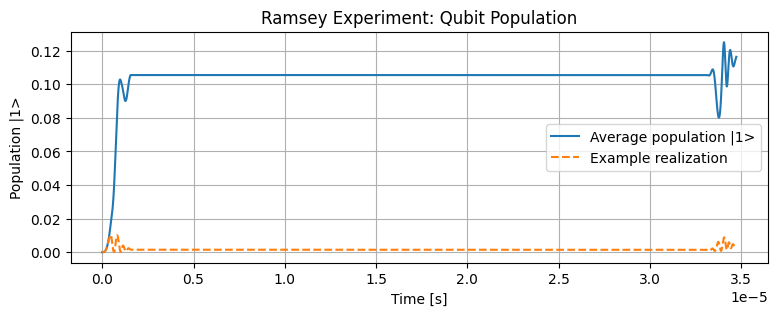

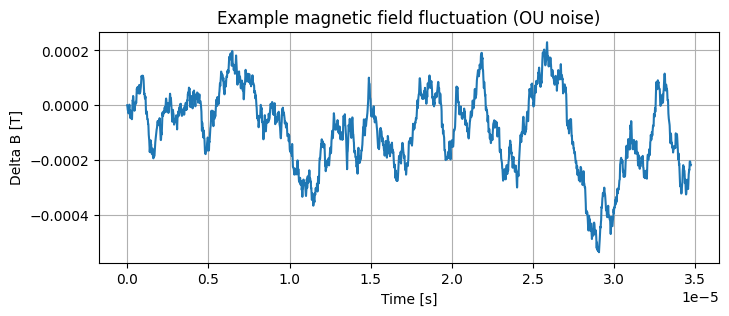

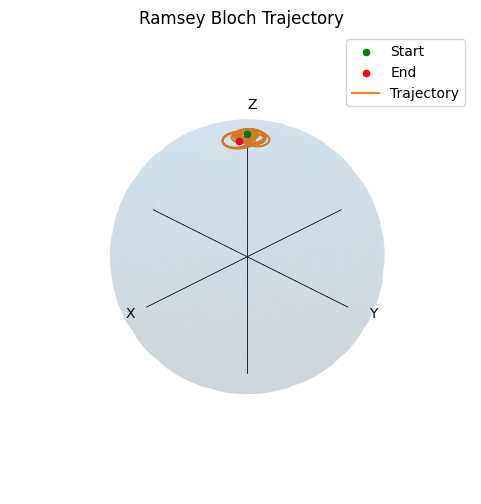

[hyperfine-verynoisy] tau=3.162e-05 s -> contrast 0.3441


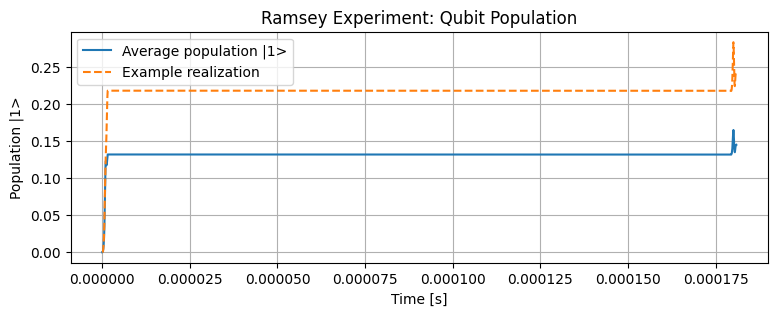

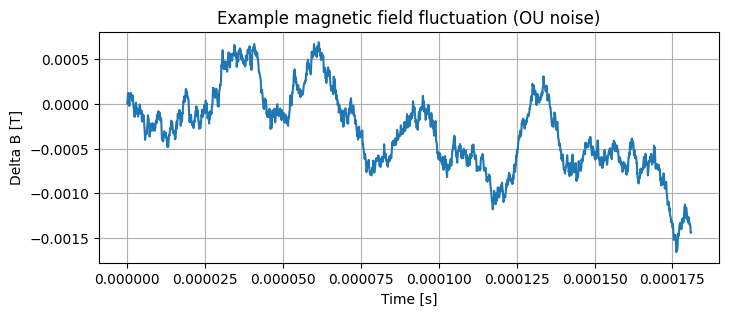

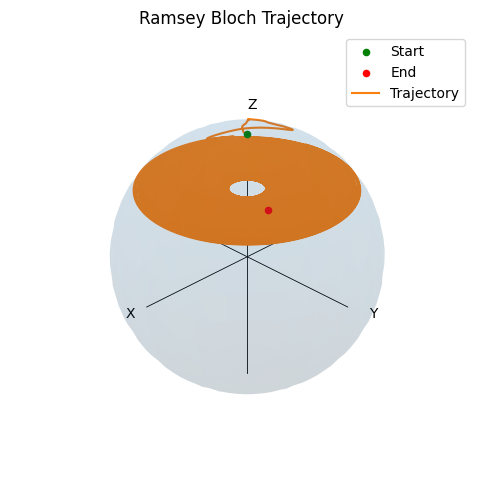

[hyperfine-verynoisy] tau=1.778e-04 s -> contrast 0.1132


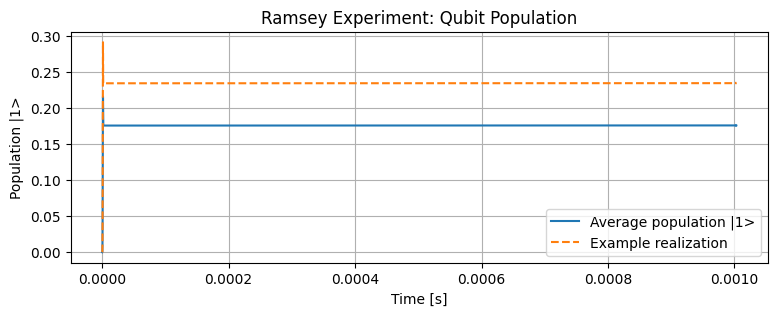

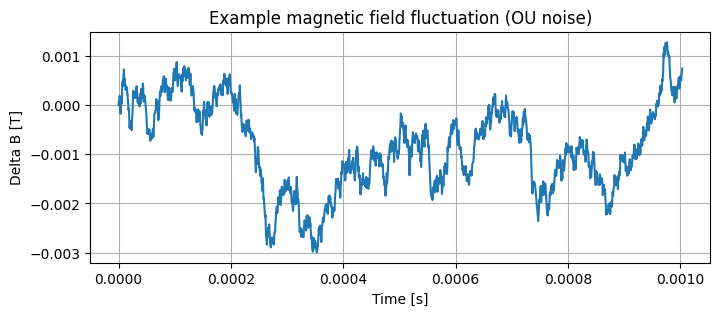

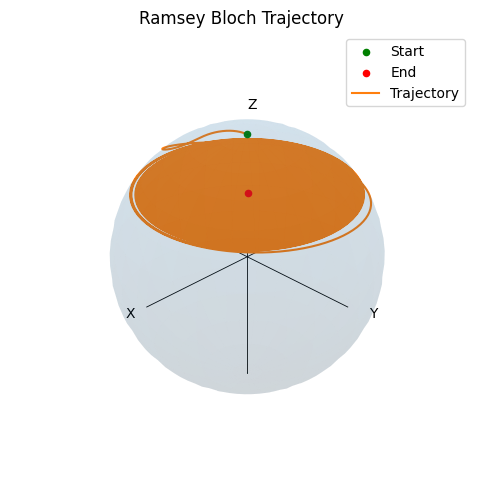

[hyperfine-verynoisy] tau=1.000e-03 s -> contrast 0.0025


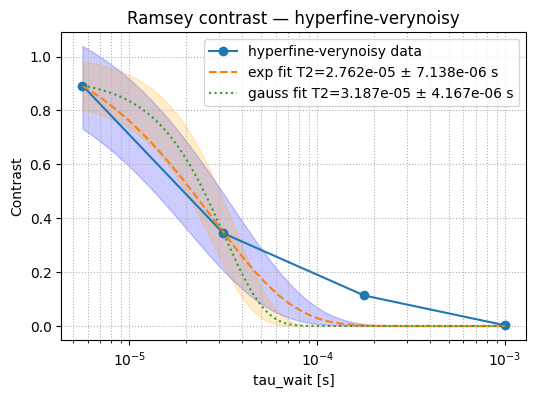

Hyperfine very noisy exp-fit T2: 2.7622634540023015e-05
Running hyperfine (stable) example...


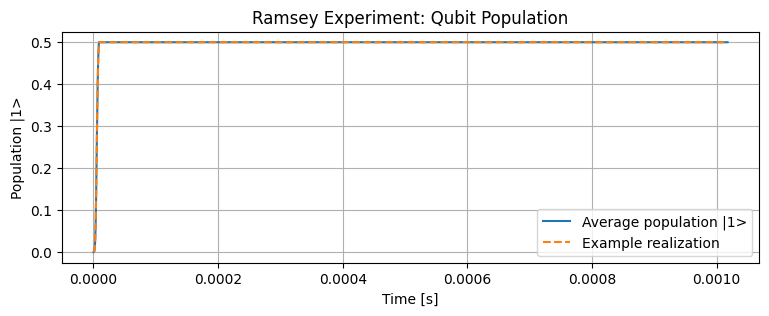

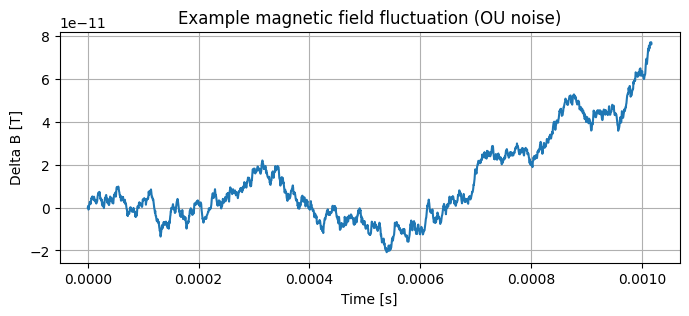

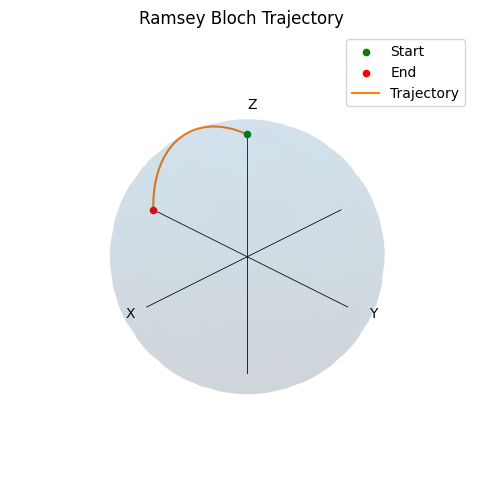

[hyperfine-stable] tau=1.000e-03 s -> contrast 0.9998


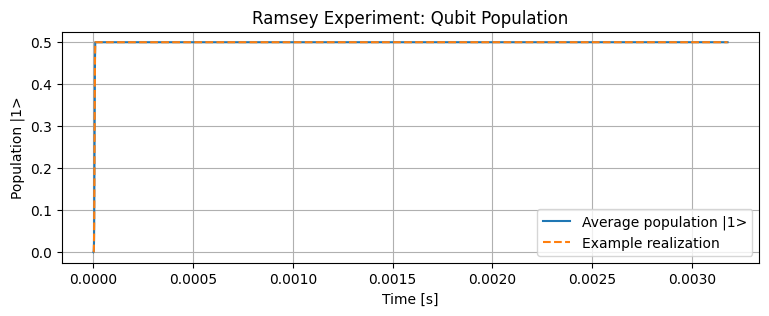

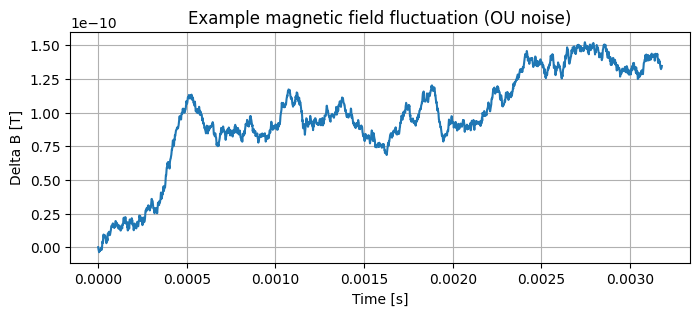

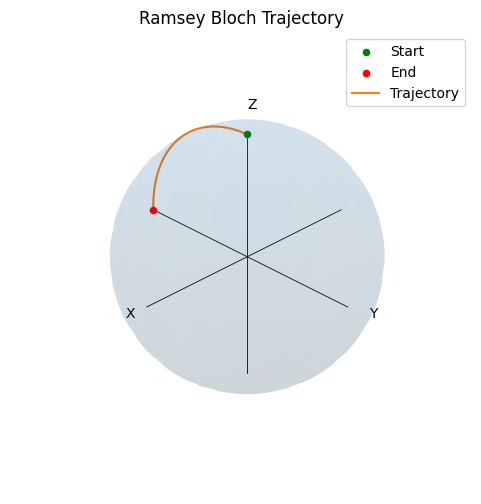

[hyperfine-stable] tau=3.162e-03 s -> contrast 0.9994


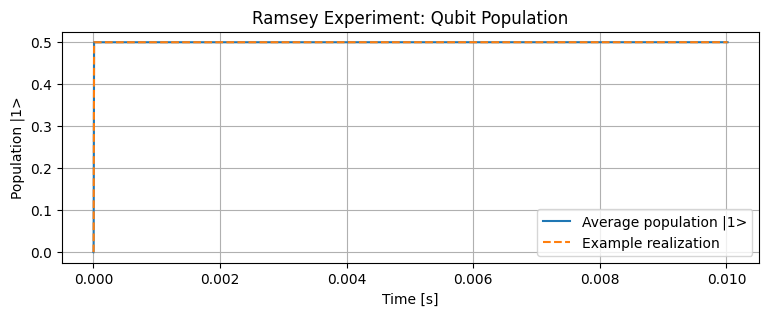

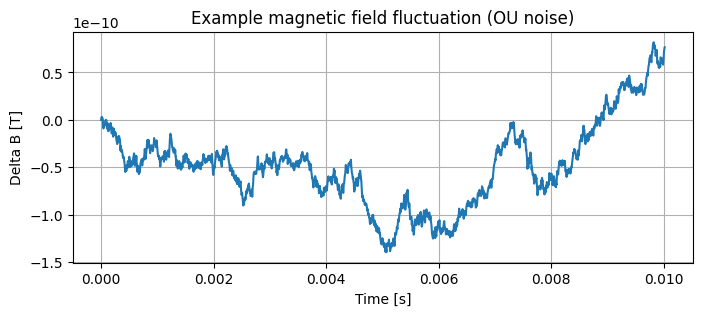

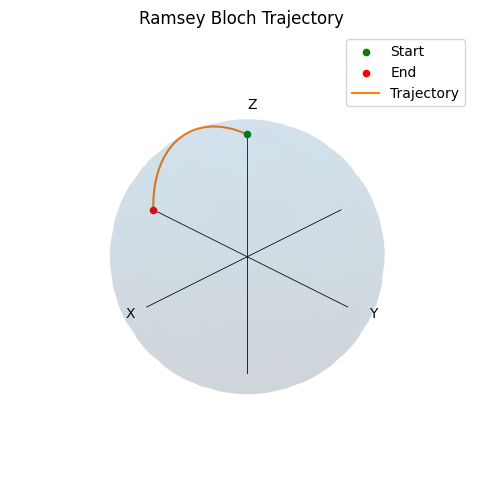

[hyperfine-stable] tau=1.000e-02 s -> contrast 0.9982


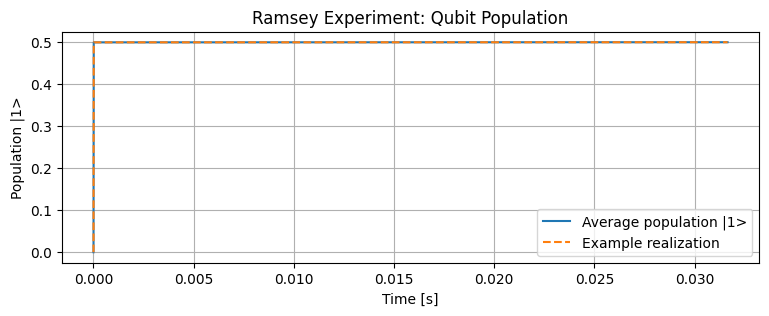

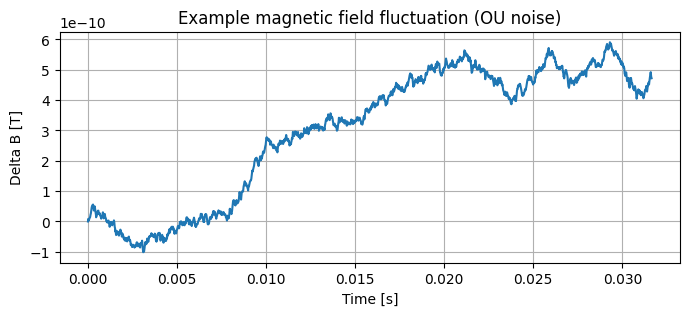

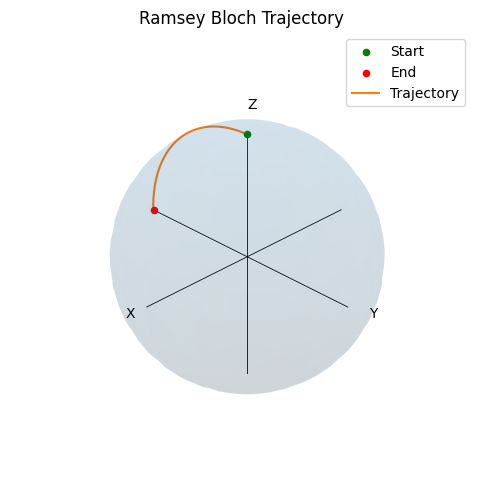

[hyperfine-stable] tau=3.162e-02 s -> contrast 0.9944


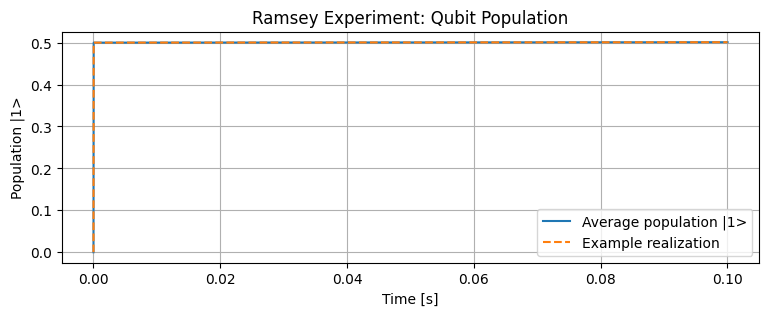

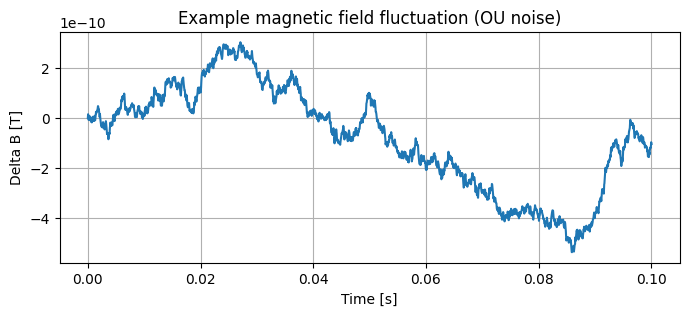

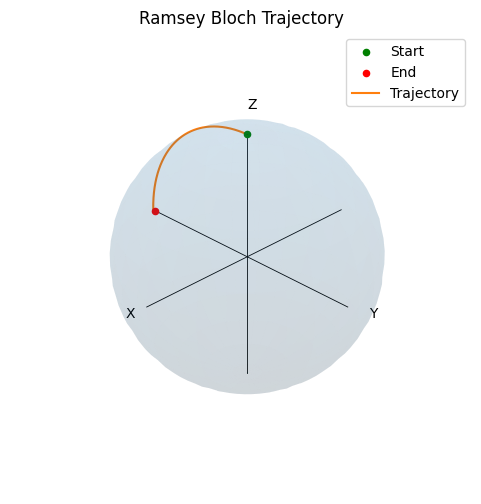

[hyperfine-stable] tau=1.000e-01 s -> contrast 0.9825


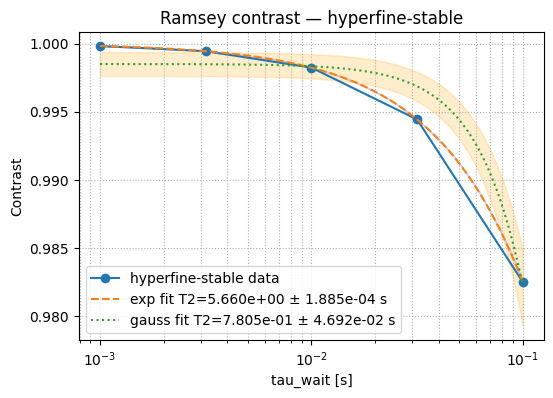

Hyperfine stable exp-fit T2: 5.66041219903517

Running optical (noisy) example...
Skipping tau=1.00e-06s (shorter than pi/2 pulse 5.00e-06s)


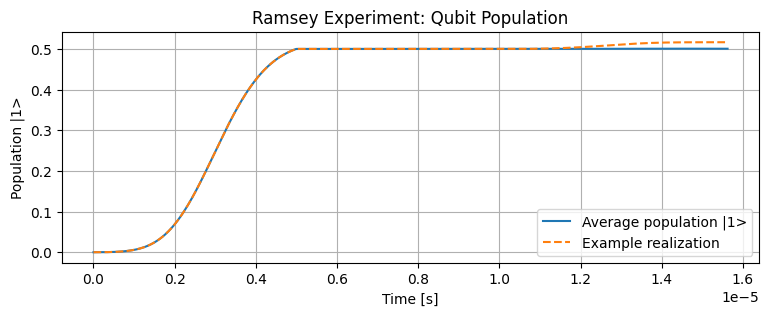

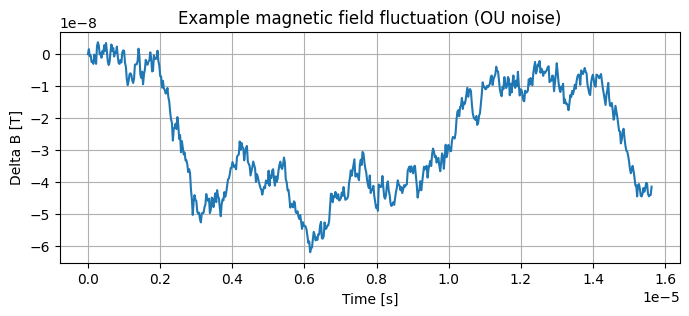

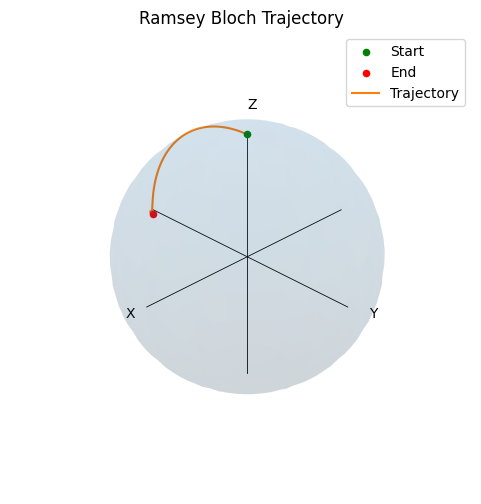

[optical-noisy] tau=5.623e-06 s -> contrast 0.9982


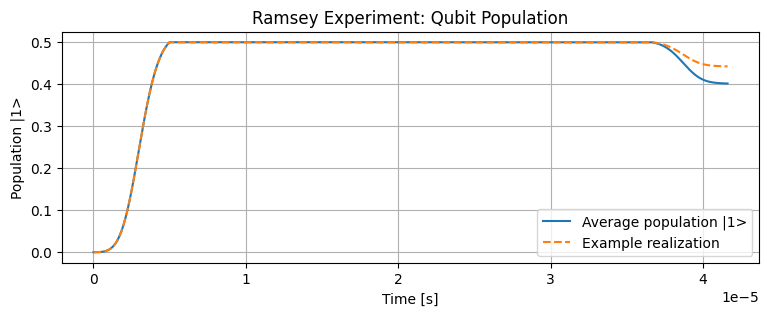

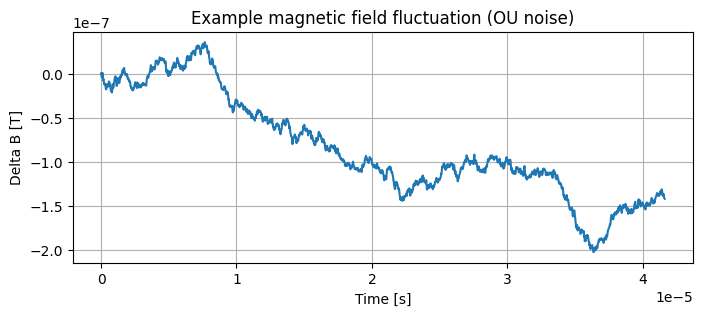

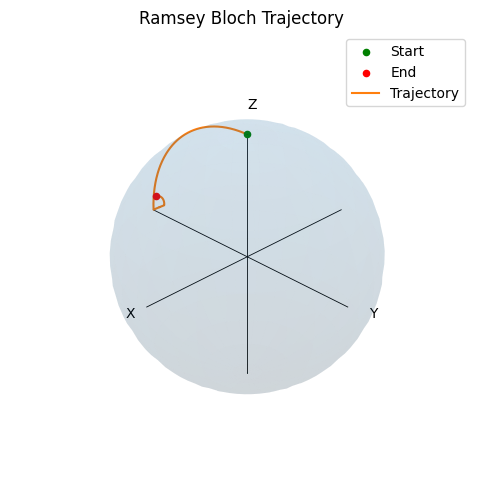

[optical-noisy] tau=3.162e-05 s -> contrast 0.9729


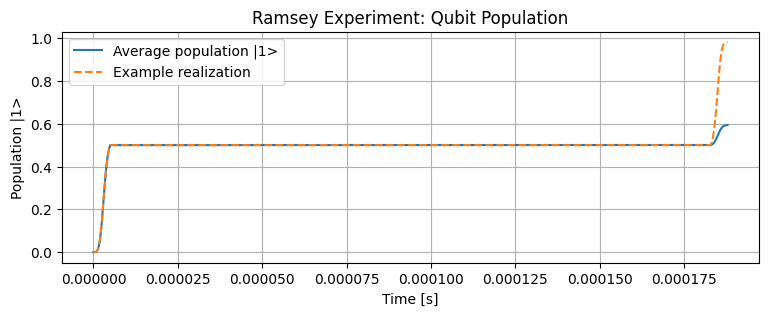

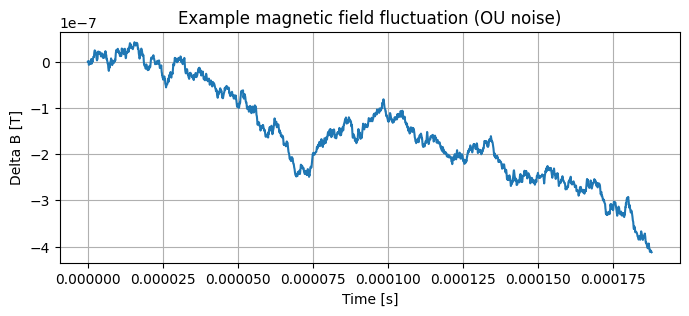

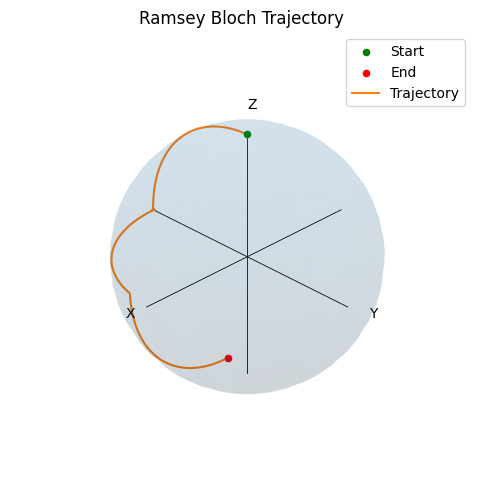

[optical-noisy] tau=1.778e-04 s -> contrast 0.2928


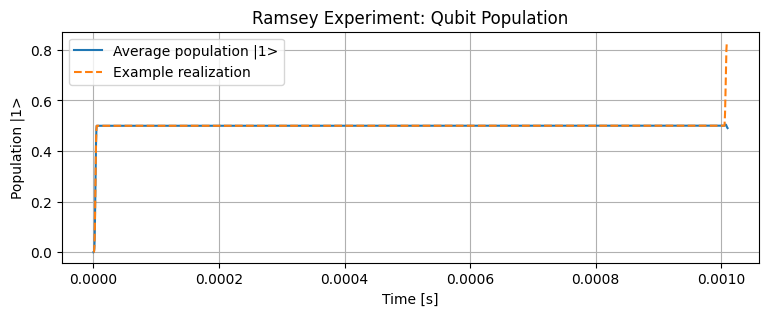

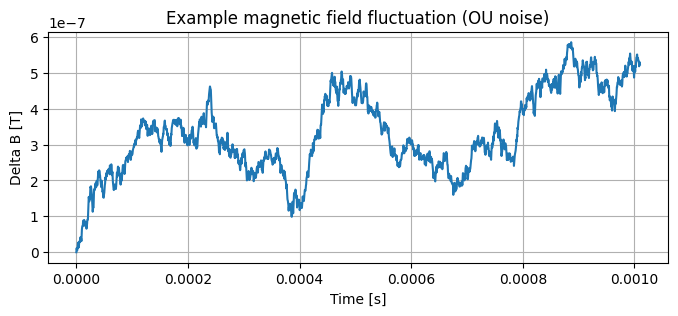

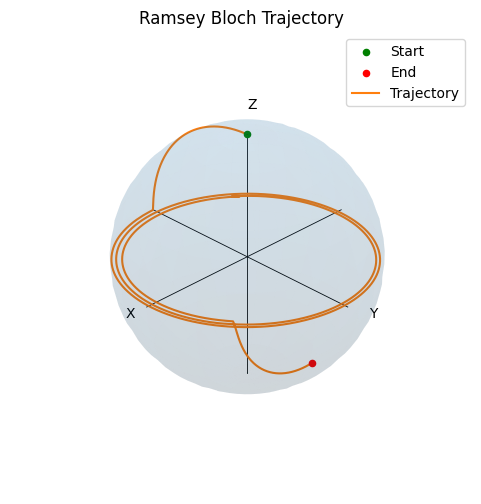

[optical-noisy] tau=1.000e-03 s -> contrast 0.5977


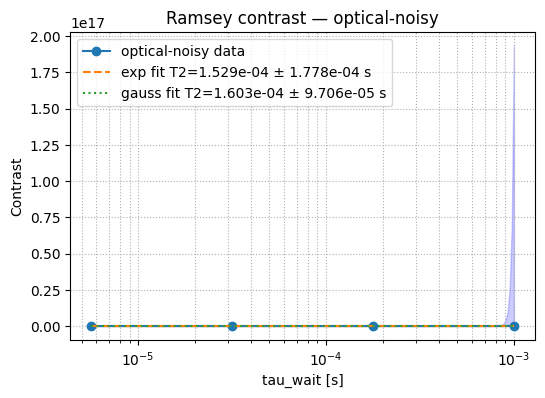

Optical noisy exp-fit T2: 0.00015285223106134175

Running hyperfine (noisy) example...
Skipping tau=1.00e-06s (shorter than pi/2 pulse 1.55e-06s)


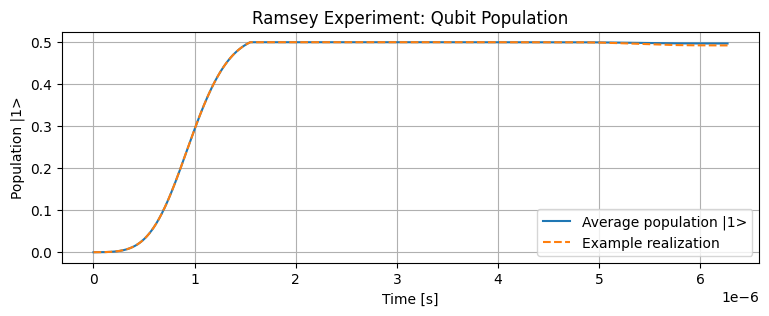

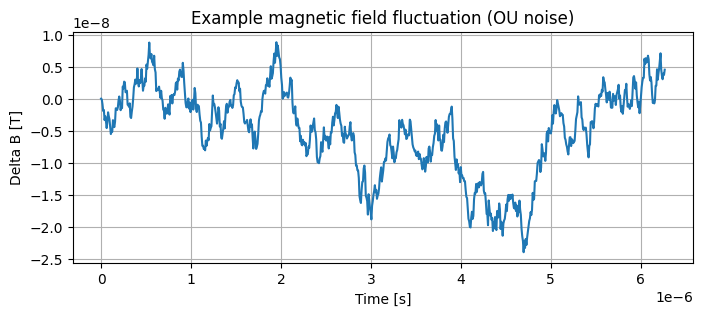

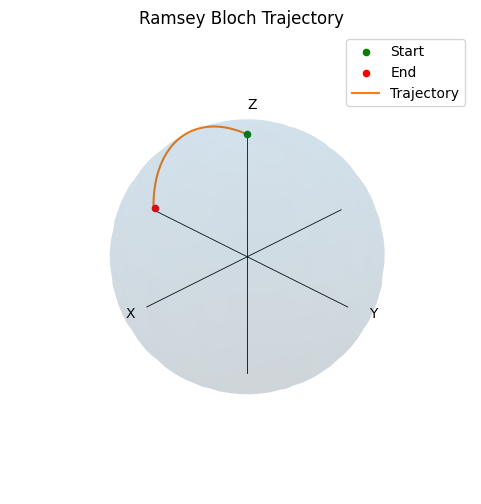

[hyperfine-noisy] tau=3.162e-06 s -> contrast 0.9872


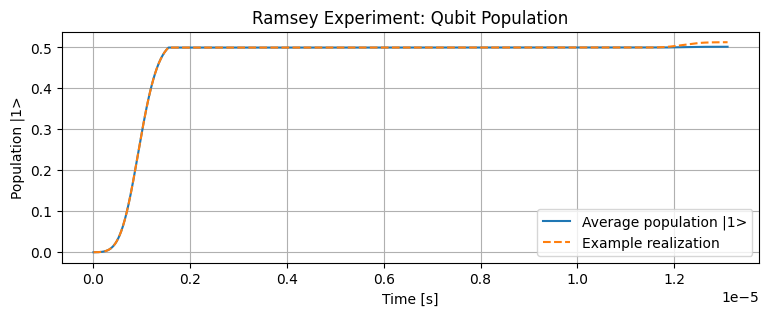

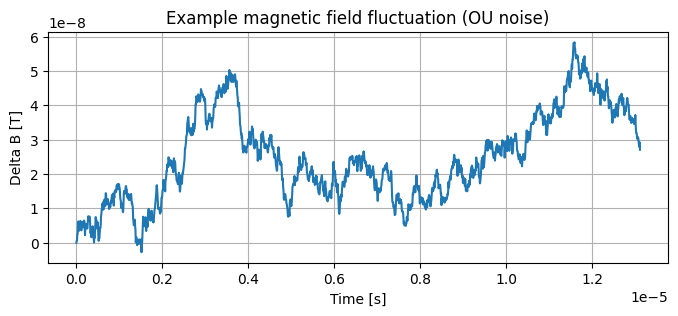

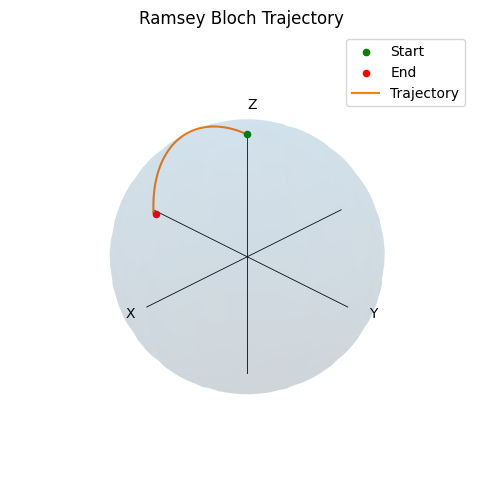

[hyperfine-noisy] tau=1.000e-05 s -> contrast 0.9715


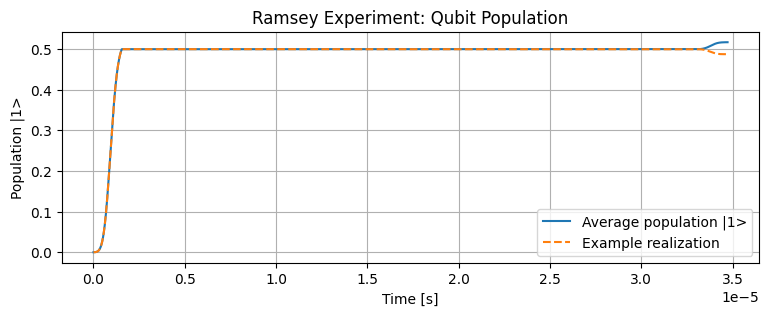

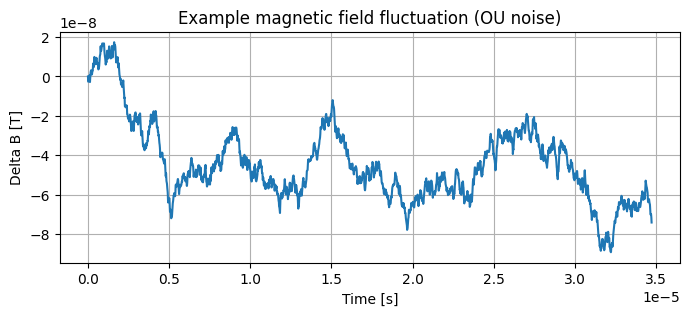

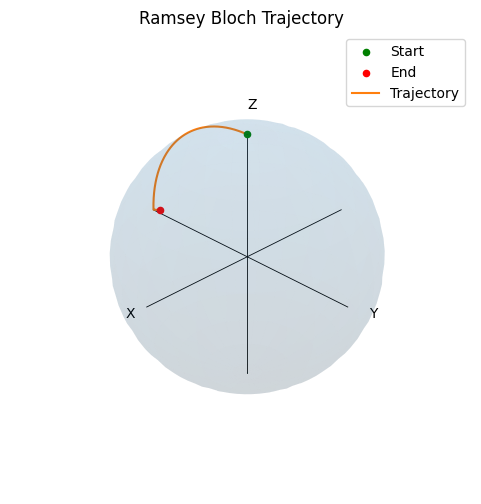

[hyperfine-noisy] tau=3.162e-05 s -> contrast 0.9216


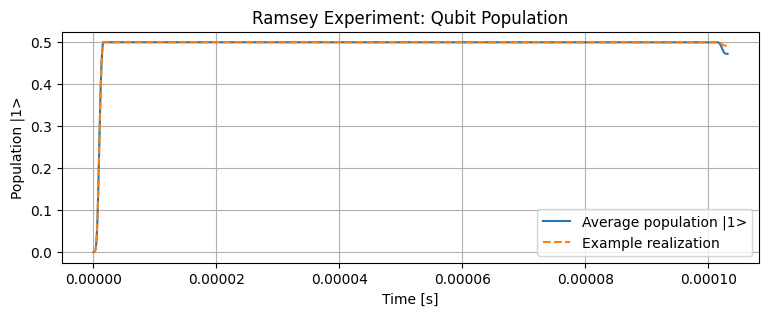

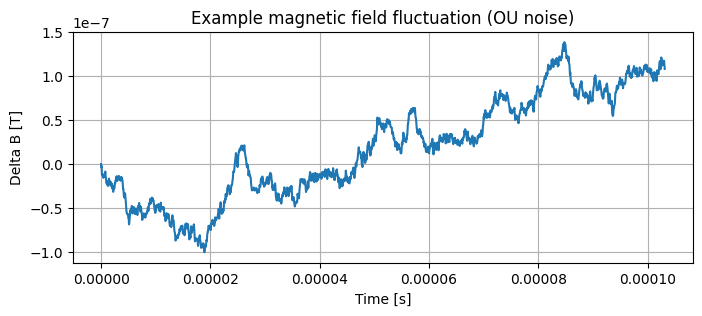

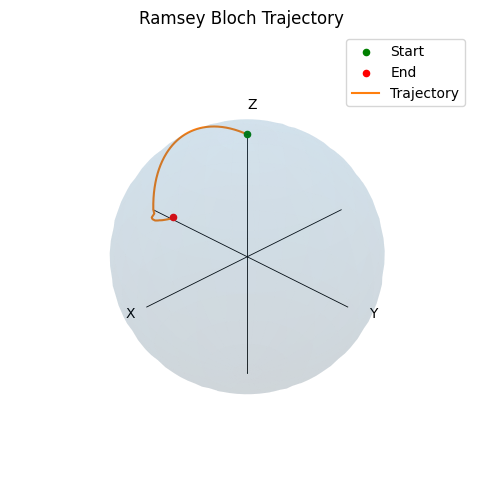

[hyperfine-noisy] tau=1.000e-04 s -> contrast 0.7853


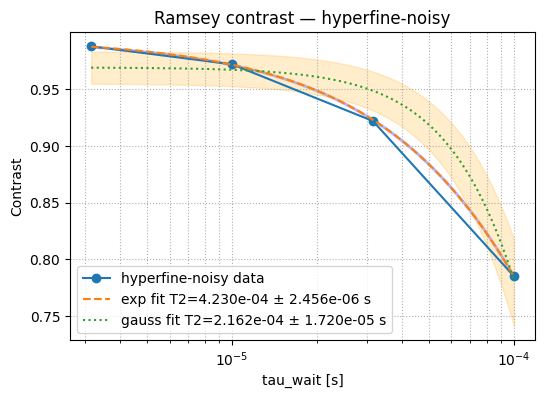

Hyperfine noisy exp-fit T2: 0.00042299893668463974

Done.


In [ ]:
#Final version of the robust ramsey simulation code with 3 example parameter sets
import numpy as np
import matplotlib.pyplot as plt
from qutip import basis, sigmax, sigmay, sigmaz, sigmam, mesolve
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

#pauli matrices and projection operator for later
sx = sigmax()
sy = sigmay()
sz = sigmaz()
proj1 = basis(2, 1) * basis(2, 1).dag()  # |1><1|
#this is just for plotting the bloch sphere later
def plot_bloch_sphere(ax, alpha=0.15):
    # draw a unit sphere
        u = np.linspace(0, 2*np.pi, 60)
        v = np.linspace(0, np.pi, 30)
        x = np.outer(np.cos(u), np.sin(v))
        y = np.outer(np.sin(u), np.sin(v))
        z = np.outer(np.ones_like(u), np.cos(v))
        ax.plot_surface(x, y, z, rstride=2, cstride=2, linewidth=0, alpha=alpha, zorder=0)
        # axes lines
        ax.plot([-1,1],[0,0],[0,0],'k-', lw=0.6)
        ax.plot([0,0],[-1,1],[0,0],'k-', lw=0.6)
        ax.plot([0,0],[0,0],[-1,1],'k-', lw=0.6)
        # axis labels
        ax.text(1.2, 0, 0, 'X', fontsize=10)
        ax.text(0, 1.2, 0, 'Y', fontsize=10)
        ax.text(0, 0, 1.2, 'Z', fontsize=10)
        ax.set_xlim([-1,1]); ax.set_ylim([-1,1]); ax.set_zlim([-1,1])
        ax.set_box_aspect((1,1,1))
        ax.axis('off')

#generating the noise
def generate_ou_noise(n_steps, dt, tau, sigma_field, rng=None):
    if rng is None:
        rng = np.random.default_rng() #random number generator
    if tau <= 0:
        return sigma_field * rng.standard_normal(n_steps)
    alpha = np.exp(-dt / tau)
    sigma = sigma_field * np.sqrt(1 - alpha**2)
    x = np.zeros(n_steps)
    for k in range(1, n_steps):
        x[k] = alpha * x[k-1] + sigma * rng.standard_normal() #sigma: noise strength; alpha: decay of the correlation; #tau: correlation time
    return x

#shaping the pulses
def gaussian_pulse(times, start, duration, amp, sigma_fraction=0.25):
    pulse = np.zeros_like(times, dtype=float)
    center = start + 0.5 * duration #center of the pulse; for the peak
    sigma = max(sigma_fraction * duration, 1e-15) #width of the pulse, make sure it's not zero
    mask = (times >= start) & (times < start + duration) #mask to apply the pulse only in the duration
    tloc = times[mask]
    if tloc.size > 0:
        pulse[mask] = amp * np.exp(-0.5 * ((tloc - center) / sigma) ** 2)
    return pulse

#adding the two pulses together, with the second pulse having a relative phase
def build_ramsey_pulses(times, omega_amp, pi_over_2_duration, tau_wait, phase2=np.pi/2, sigma_fraction=0.25):
    # position of the pulses
    t0_pulse1 = 0.0
    t0_pulse2 = pi_over_2_duration + tau_wait
    #using previous function for shape
    p1 = gaussian_pulse(times, t0_pulse1, pi_over_2_duration, omega_amp, sigma_fraction=sigma_fraction)
    p2 = gaussian_pulse(times, t0_pulse2, pi_over_2_duration, omega_amp, sigma_fraction=sigma_fraction)
    # decompose second pulse into x and y components with given phase of the second pulse
    p2_x = p2 * np.cos(phase2)
    p2_y = p2 * np.sin(phase2)

    area_p1 = np.trapezoid(p1, times)
    area_p2 = np.trapezoid(p2, times)

    # normalize to ensure pi/2 area
    if area_p1 > 0:
        p1 *= (np.pi / 2.0) / area_p1
    if area_p2 > 0:
        p2_x *= (np.pi / 2.0) / area_p2
        p2_y *= (np.pi / 2.0) / area_p2

    Omega_x = p1 + p2_x #first pulse along x, second pulse decomposed
    Omega_y = p2_y #only y component from second pulse
    return Omega_x.astype(float), Omega_y.astype(float)

def make_time_grid_uniform(pi_over_2_duration, tau_wait, tpad=0.0, samples_per_pulse=300, min_free_points=5):
    # ensure sensible values for the time grid, this is for the stability of the solver when iterating over different taus
    # make sure there are enough time points in each section of the sequence
    # minimum 8 points per pulse, minimum 2 points in free evolution
    # return time array
    samples_per_pulse = max(int(samples_per_pulse), 8)
    min_free_points = max(int(min_free_points), 2)

    t_pulse = float(pi_over_2_duration)
    dt = t_pulse / float(samples_per_pulse)

    if tau_wait is None or tau_wait <= 0.0:
        n_free = 0
    else:
        n_free = max(min_free_points, int(np.ceil(tau_wait / dt)))

    n_pad = 0
    if tpad and tpad > 0.0:
        n_pad = max(1, int(np.ceil(tpad / dt)))

    n_total = samples_per_pulse + n_free + samples_per_pulse + n_pad
    n_total = max(n_total, 5)

    total_duration = 2.0 * t_pulse + (tau_wait if tau_wait is not None else 0.0) + tpad
    times = np.linspace(0.0, total_duration, n_total, endpoint=True)

    return times.astype(float)


# this is much quicker and more robust than all other previous attempts

def run_ramsey_ensemble_robust(
    Delta0,
    Omega_amp,
    pi_over_2_duration,
    tau_wait,
    T1,
    Tphi,
    tau_corr,
    sigma_field,
    field_sensitivity,
    n_realizations,
    tpad=0.0,
    samples_per_pulse=300, #this would be statistically better, but takes a really long time to compute
    min_free_points=5,
    rng=None,
):
    if rng is None:
        rng = np.random.default_rng()

    # Require tau_wait >= 0; 
    if tau_wait < 0:
        raise ValueError("tau_wait must be non-negative")

    

    # Build time grid
    times = make_time_grid_uniform(pi_over_2_duration, tau_wait, tpad,
                                   samples_per_pulse=samples_per_pulse,
                                   min_free_points=min_free_points)
    n_steps = len(times)

    # Build pulses on the same grid
    Omega_x_arr, Omega_y_arr = build_ramsey_pulses(times, Omega_amp, pi_over_2_duration, tau_wait)
    Omega_x_arr = np.ascontiguousarray(Omega_x_arr, dtype=float)
    Omega_y_arr = np.ascontiguousarray(Omega_y_arr, dtype=float)

    # Preallocate outputs
    pop_matrix = np.zeros((n_realizations, n_steps))
    bloch_matrix = np.zeros((n_realizations, n_steps, 3))

    rho0 = basis(2, 0) * basis(2, 0).dag()

    # Coarse grid for OU, to reduce computation
    n_noise = min(2000, max(200, n_steps))
    t_noise = np.linspace(0.0, times[-1], n_noise)
    dt_noise = t_noise[1] - t_noise[0]

    Hx = 0.5 * sigmax()
    Hy = 0.5 * sigmay()
    Hz = 0.5 * sigmaz()

    for r in range(n_realizations):
        #creating noise, detuning from noise and time dependent Delta for the hamiltonian 
        ou_coarse = generate_ou_noise(n_noise, dt_noise, tau_corr, sigma_field, rng=rng)
        delta_field = np.interp(times, t_noise, ou_coarse).astype(float)
        Delta_t_arr = (Delta0 + delta_field * field_sensitivity).astype(float)

        # check lengths
        if not (len(times) == len(Omega_x_arr) == len(Omega_y_arr) == len(Delta_t_arr)):
            
            print("LENGTH MISMATCH (should not happen):")
            print("len(times)   =", len(times))
            print("len(Omega_x) =", len(Omega_x_arr))
            print("len(Omega_y) =", len(Omega_y_arr))
            print("len(Delta_t) =", len(Delta_t_arr))
            raise RuntimeError("Length mismatch in robust runner")

        # continuous functions for QuTiP
        fx = interp1d(times, Omega_x_arr, kind='linear', bounds_error=False, fill_value=0.0)
        fy = interp1d(times, Omega_y_arr, kind='linear', bounds_error=False, fill_value=0.0)
        fD = interp1d(times, Delta_t_arr, kind='linear', bounds_error=False, fill_value=(float(Delta_t_arr[0]), float(Delta_t_arr[-1])))
        #last one: nonzero outside bounds, since detuning may be nonzero before/after pulses



        # wrapper functions QuTiP mesolve requires float 
        def coeff_Ox(t, args=None, fx=fx):
            return float(fx(t))

        def coeff_Oy(t, args=None, fy=fy):
            return float(fy(t))

        def coeff_Dt(t, args=None, fD=fD):
            return float(fD(t))


        H = [
            [Hx, coeff_Ox],
            [Hy, coeff_Oy],
            [Hz, coeff_Dt]
        ]

        # collapse operators
        c_ops = []
        if T1 is not None and T1 > 0:
            c_ops.append(np.sqrt(1.0 / T1) * sigmam())
        if Tphi is not None and Tphi > 0:
            # Choose convention so off-diagonals decay ~ exp(-t/Tphi) for large Tphi
            c_ops.append(np.sqrt(1.0 / (2.0 * Tphi)) * sigmaz())

        e_ops = [sx, sy, sz, proj1]

        # Solve
        result = mesolve(H, rho0, times, c_ops, e_ops=e_ops)
        expect = np.array(result.expect)
        pop = np.real(expect[-1, :])
        bloch = np.real(expect[0:3, :].T)

        pop_matrix[r, :] = pop
        bloch_matrix[r, :, :] = bloch
    #plot population data
    pop_avg = pop_matrix.mean(axis=0)
    last_delta_field = delta_field  # last realization
    plt.figure(figsize=(9, 3))
    plt.plot(times, pop_avg, label="Average population |1>")
    plt.plot(times, pop_matrix[0, :], "--", label="Example realization")
    plt.xlabel("Time [s]")
    plt.ylabel("Population |1>")
    plt.title("Ramsey Experiment: Qubit Population")
    plt.legend()
    plt.grid(True)
    #plot magnetic field noise
    plt.figure(figsize=(8, 3))
    plt.plot(times, last_delta_field)
    plt.xlabel("Time [s]")
    plt.ylabel("Delta B [T]")
    plt.title("Example magnetic field fluctuation (OU noise)")
    plt.grid(True)
    plt.show()


    # Bloch Sphere Trajectory Plot
   
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    plot_bloch_sphere(ax, alpha=0.1)
    bloch_example = bloch_matrix[0, :, :]
    ax.scatter([bloch_example[0,0]], [bloch_example[0,1]], [bloch_example[0,2]], color='green', label='Start')
    ax.scatter([bloch_example[-1,0]], [bloch_example[-1,1]], [bloch_example[-1,2]], color='red', label='End')
    ax.plot(bloch_example[:,0], bloch_example[:,1], bloch_example[:,2], lw=1.5, label='Trajectory')

    ax.set_title('Ramsey Bloch Trajectory')
    ax.view_init(elev=30, azim=45)
    ax.legend()
    plt.show()
    plt.show()
    return times, pop_avg, pop_matrix[0, :], last_delta_field, pop_matrix, bloch_matrix[0, :, :], bloch_matrix

# Contrast extraction & fitting helpers
# Contrast is the magnitude of the transverse component of the bloch vector
# Need the contrast from the final bloch vectors
# we can fit the contrast decay to exponential or gaussian


def contrast_from_bloch_matrix(bloch_matrix):
    # bloch_matrix shape: (n_realizations, n_times, 3)
    mean_X = np.mean(bloch_matrix[:, -1, 0])
    mean_Y = np.mean(bloch_matrix[:, -1, 1])
    return np.sqrt(mean_X**2 + mean_Y**2)

def fit_decay(tau_list, contrast, model='exp'):
    if model == 'exp':
        def func(t, T2, C0): return C0 * np.exp(-t / T2)
        p0 = [np.mean(tau_list) or 1.0, contrast[0] if contrast.size>0 else 1.0]
    else:
        # gaussian
        def func(t, T2, C0): return C0 * np.exp(-(t / T2)**2)
        p0 = [np.mean(tau_list) or 1.0, contrast[0] if contrast.size>0 else 1.0]
    try:
        popt, pcov = curve_fit(func, tau_list, contrast, p0=p0, maxfev=20000)
        return popt, pcov, func
    except Exception as e:
        print("Fit failed:", e)
        return None, None, func


def example_hyperfine_stable():
    # Long T2 ~ 6 s observed in lab; very stable magnetic field
    Omega_amp = 2.0 * np.pi * 28.56e3        
    pi_over_2_duration = np.pi / (2.0 * Omega_amp)
    params = dict(
        Delta0=0.0,
        Omega_amp=Omega_amp,
        pi_over_2_duration=pi_over_2_duration,
        tau_wait=None,      # will be set per sweep
        T1=50.0,
        Tphi=6.0,           # pure dephasing chosen ~6 s
        tau_corr=1.0,       # irrelevant because sigma tiny
        sigma_field=1e-9,   # 1 nT RMS
        field_sensitivity=1.0 * np.pi * 1e7,  
        n_realizations=2,
        tpad=0.0
    )
    return params

def example_optical_noisy():
    # Optical qubit with noisy magnetic field -> measurable ms timescale decay
    Omega_amp = 2.0 * np.pi * 50e3    
    pi_over_2_duration = np.pi / (2.0 * Omega_amp)
    params = dict(
        Delta0=0.0,
        Omega_amp=Omega_amp,
        pi_over_2_duration=pi_over_2_duration,
        tau_wait=None,
        T1=20.0,
        Tphi=1e-2,
        tau_corr=1e-2,
        sigma_field=1e-6,   
        field_sensitivity=28 * np.pi * 1e9,  
        n_realizations=2,
        tpad=0.0
    )
    return params

def example_hyperfine_noisy():
    # Hyperfine qubit but noisy field -> data for qubit taken from paper mw0
    Omega_amp = 2.0 * np.pi * 161e3       # Rabi
    pi_over_2_duration = np.pi / (2.0 * Omega_amp)
    params = dict(
        Delta0=0.0,
        Omega_amp=Omega_amp,
        pi_over_2_duration=pi_over_2_duration,
        tau_wait=None,
        T1=20.0,
        Tphi=0.43e-3,
        tau_corr=1e-2,
        sigma_field=1e-6,   
        field_sensitivity=-21 * np.pi * 1e9,  
        n_realizations=2,
        tpad=0.0
    )
    return params
def example_hyperfine_verynoisy():
    # Hyperfine qubit with very noisy field -> short T2*
    Omega_amp = 2.0 * np.pi * 161e3       # Rabi
    pi_over_2_duration = np.pi / (2.0 * Omega_amp)
    params = dict(
        Delta0=0.0,
        Omega_amp=Omega_amp,
        pi_over_2_duration=pi_over_2_duration,
        tau_wait=None,
        T1=20.0,
        Tphi=0.1e-3,
        tau_corr=1e-4,
        sigma_field=1e-3,   
        field_sensitivity=-21 * np.pi * 1e9, 
        n_realizations=2,
        tpad=0.0
    )
    return params

# sweeping over taus, taking contrast and plotting
def run_sweep_and_plot(params, tau_wait_list, label="case", samples_per_pulse=300, min_free_points=5):
    contrasts = []
    taus_used = []
    for tau in tau_wait_list:
        # skip tau shorter than pulse (avoid pulse overlap) — physically meaningless
        if tau < params['pi_over_2_duration']:
            print(f"Skipping tau={tau:.2e}s (shorter than pi/2 pulse {params['pi_over_2_duration']:.2e}s)")
            continue
        # run
        out = run_ramsey_ensemble_robust(
            Delta0=params['Delta0'],
            Omega_amp=params['Omega_amp'],
            pi_over_2_duration=params['pi_over_2_duration'],
            tau_wait=tau,
            T1=params['T1'],
            Tphi=params['Tphi'],
            tau_corr=params['tau_corr'],
            sigma_field=params['sigma_field'],
            field_sensitivity=params['field_sensitivity'],
            n_realizations=params['n_realizations'],
            tpad=params.get('tpad', 0.0),
            samples_per_pulse=samples_per_pulse,
            min_free_points=min_free_points,
        )
        times, pop_avg, pop_example, last_delta_field, pop_matrix, bloch_example, bloch_matrix = out
        C = contrast_from_bloch_matrix(bloch_matrix)
        contrasts.append(C)
        taus_used.append(tau)
        print(f"[{label}] tau={tau:.3e} s -> contrast {C:.4f}")

    taus_used = np.array(taus_used)
    contrasts = np.array(contrasts)

    # Fit exponential and gaussian 
    popt_exp, pcov_exp, func_exp = fit_decay(taus_used, contrasts, model='exp')
    popt_gau, pcov_gau, func_gau = fit_decay(taus_used, contrasts, model='gauss')
    
    plt.figure(figsize=(6,4))
    plt.semilogx(taus_used, contrasts, 'o-', label=f"{label} data")

    # Fine tau grid for plotting
    ts_fine = np.logspace(np.log10(taus_used.min()) if taus_used.size>0 else -6,
                      np.log10(taus_used.max()) if taus_used.size>0 else -1, 200)

    # Exponential fit with uncertainty
    if popt_exp is not None:
        T2_exp = popt_exp[0]
        T2_exp_err = np.sqrt(np.diag(pcov_exp))[0]
        plt.semilogx(ts_fine, func_exp(ts_fine, *popt_exp), '--', label=f"exp fit T2={T2_exp:.3e} ± {T2_exp_err:.3e} s")
        # Compute standard deviation of the fit
        sigma_exp = np.sqrt(np.diag(pcov_exp))
        y_exp_upper = func_exp(ts_fine, *(popt_exp + sigma_exp))
        y_exp_lower = func_exp(ts_fine, *(popt_exp - sigma_exp))
        plt.fill_between(ts_fine, y_exp_lower, y_exp_upper, color='blue', alpha=0.2)

    # Gaussian fit with uncertainty
    if popt_gau is not None:
        T2_gau = popt_gau[0]
        T2_gau_err = np.sqrt(np.diag(pcov_gau))[0]
        plt.semilogx(ts_fine, func_gau(ts_fine, *popt_gau), ':', label=f"gauss fit T2={T2_gau:.3e} ± {T2_gau_err:.3e} s")
        sigma_gau = np.sqrt(np.diag(pcov_gau))
        y_gau_upper = func_gau(ts_fine, *(popt_gau + sigma_gau))
        y_gau_lower = func_gau(ts_fine, *(popt_gau - sigma_gau))
        plt.fill_between(ts_fine, y_gau_lower, y_gau_upper, color='orange', alpha=0.2)

    plt.xlabel("tau_wait [s]")
    plt.ylabel("Contrast")
    plt.title(f"Ramsey contrast — {label}")
    plt.grid(True, which='both', ls=':')
    plt.legend()
    plt.show()
    
    return taus_used, contrasts, popt_exp, popt_gau


# Main: 4 cases running, sweeping taus, plotting, fitting

if __name__ == "__main__":
    
    taus_hyperfine_verynoisy= np.logspace(-6,-3,5)
    taus_hyperfine_stable = np.logspace(-3, -1, 5)   
    taus_optical_noisy = np.logspace(-6, -3, 5)     
    taus_hyperfine_noisy = np.logspace(-6, -4, 5)  

    print("\nRunning hyperfine (very noisy) example...")
    p = example_hyperfine_verynoisy()
    taus_used, contrasts, pe, pg = run_sweep_and_plot(p, taus_hyperfine_verynoisy, label="hyperfine-verynoisy", samples_per_pulse=200)
    if pe is not None:
        print("Hyperfine very noisy exp-fit T2:", pe[0])

    print("Running hyperfine (stable) example...")
    p = example_hyperfine_stable()
    taus_used, contrasts, pe, pg = run_sweep_and_plot(p, taus_hyperfine_stable, label="hyperfine-stable", samples_per_pulse=200)
    if pe is not None:
        print("Hyperfine stable exp-fit T2:", pe[0])

    print("\nRunning optical (noisy) example...")
    p = example_optical_noisy()
    taus_used, contrasts, pe, pg = run_sweep_and_plot(p, taus_optical_noisy, label="optical-noisy", samples_per_pulse=200)
    if pe is not None:
        print("Optical noisy exp-fit T2:", pe[0])

    print("\nRunning hyperfine (noisy) example...")
    p = example_hyperfine_noisy()
    taus_used, contrasts, pe, pg = run_sweep_and_plot(p, taus_hyperfine_noisy, label="hyperfine-noisy", samples_per_pulse=200)
    if pe is not None:
        print("Hyperfine noisy exp-fit T2:", pe[0])

    print("\nDone.")
